# This is for the disaggregation part of the server side

In [1]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils
#from nilmtk.utils import *
#from nilmtk.dataset_converters import *
import convert_hipe
%matplotlib inline

In [4]:
# converting the .csv files into the .hdf dataset
start = time.time()
convert_hipe.main('./hipe_3_months', './hipe_3_months.hdf')
end = time.time()
print(end - start)

Output ./hipe_3_months.hdf
Loading factory 1...... 1 Processing ./hipe_3_months/MainTerminal_PhaseCount_3_geq_2017-10-01_lt_2018-01-01.csv
2 Processing ./hipe_3_months/ChipPress_PhaseCount_3_geq_2017-10-01_lt_2018-01-01.csv
3 Processing ./hipe_3_months/ChipSaw_PhaseCount_3_geq_2017-10-01_lt_2018-01-01.csv
4 Processing ./hipe_3_months/HighTemperatureOven_PhaseCount_3_geq_2017-10-01_lt_2018-01-01.csv
5 Processing ./hipe_3_months/PickAndPlaceUnit_PhaseCount_2_geq_2017-10-01_lt_2018-01-01.csv
6 Processing ./hipe_3_months/ScreenPrinter_PhaseCount_2_geq_2017-10-01_lt_2018-01-01.csv
7 Processing ./hipe_3_months/SolderingOven_PhaseCount_3_geq_2017-10-01_lt_2018-01-01.csv
8 Processing ./hipe_3_months/VacuumOven_PhaseCount_3_geq_2017-10-01_lt_2018-01-01.csv
9 Processing ./hipe_3_months/VacuumPump1_PhaseCount_3_geq_2017-10-01_lt_2018-01-01.csv
10 Processing ./hipe_3_months/VacuumPump2_PhaseCount_2_geq_2017-10-01_lt_2018-01-01.csv
11 Processing ./hipe_3_months/WashingMachine_PhaseCount_3_geq_2017-

## Dividing into train and test set

In [5]:
rcParams['figure.figsize'] = (13, 6)

In [ ]:
train = DataSet('./hipe_1_week.hdf')
test = DataSet('./hipe_1_week.hdf')
train.metadata

In [6]:
train = DataSet('./hipe_3_months.hdf')
test = DataSet('./hipe_3_months.hdf')

In [1]:
df_1 = next(test.buildings[1].elec[1].load())
df_1
test.buildings[1].elec[1]

NameError: name 'test' is not defined

In [7]:
building = 1

In [8]:
# the time of the samples is between 2017-10-23 and 2017-10-30
# for 3 months: 2017-10-01 and 2018-01-01
train.set_window(end="2017-11-01")
test.set_window(start="2017-11-01")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

## Visualizing the data

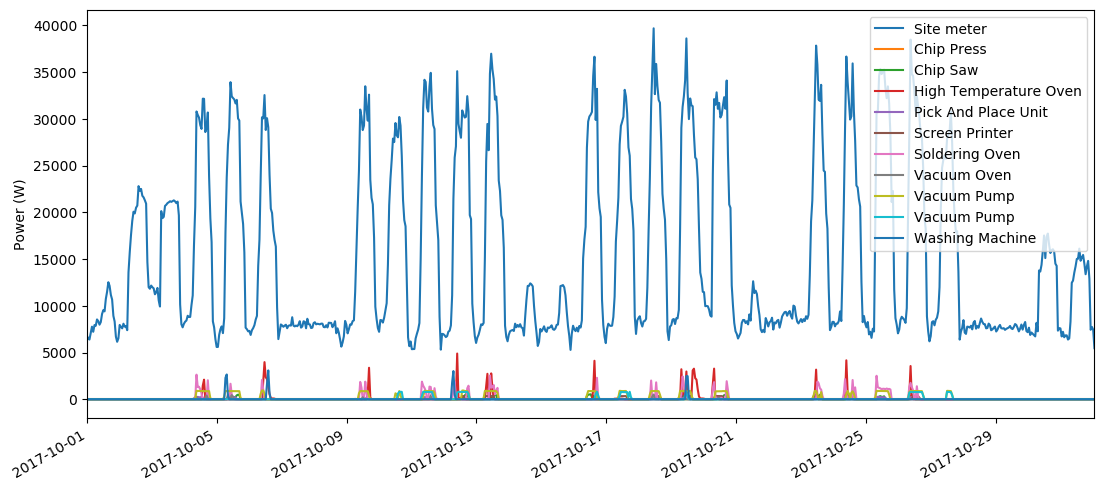

In [9]:
train_elec.plot()

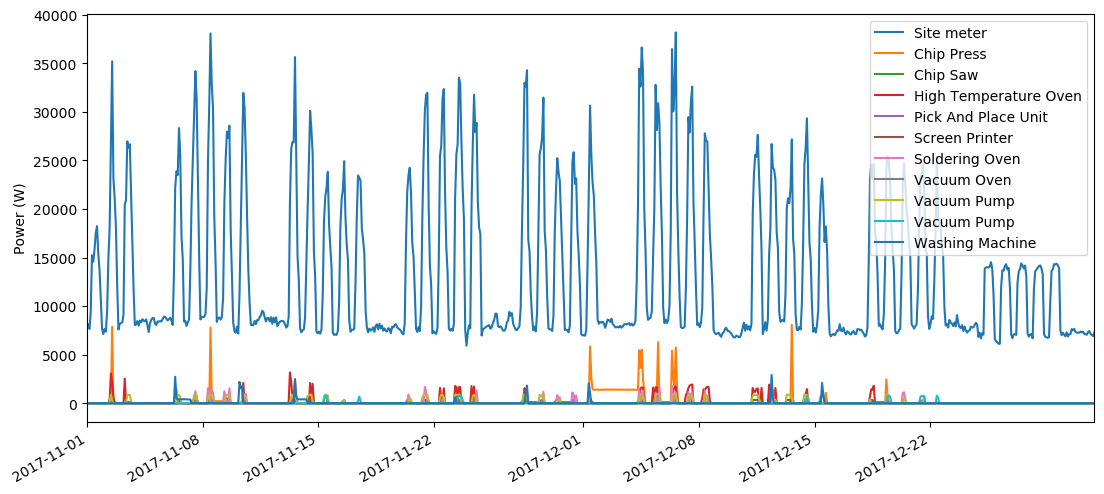

In [10]:
test_elec.plot()

In [11]:
fridge_meter = train_elec['oven']
fridge_df = next(fridge_meter.load())
fridge_df.head()

physical_quantity,power
type,active
,
2017-10-01 00:00:00.813000+02:00,0.0
2017-10-01 00:00:06.377000+02:00,0.0
2017-10-01 00:00:11.837000+02:00,0.0
2017-10-01 00:00:17.383000+02:00,0.0
2017-10-01 00:00:22.880000+02:00,0.0


In [ ]:
mains = train_elec.mains()
mains_df = next(mains.load())
mains_df.head()

## Training and disaggregation

### A function to disaggregate the mains data to constituent appliances and return the predictions

In [12]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

### Selecting top-5 appliances

In [13]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)
#top_5_train_elec = train_elec.submeters()

10/10 ElecMeter(instance=11, building=1, dataset='HIPE', appliances=[Appliance(type='washing machine', instance=1)])

In [14]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=9, building=1, dataset='HIPE', appliances=[Appliance(type='motor', instance=4)])
  ElecMeter(instance=7, building=1, dataset='HIPE', appliances=[Appliance(type='oven', instance=2)])
  ElecMeter(instance=4, building=1, dataset='HIPE', appliances=[Appliance(type='oven', instance=1)])
  ElecMeter(instance=10, building=1, dataset='HIPE', appliances=[Appliance(type='motor', instance=5)])
  ElecMeter(instance=5, building=1, dataset='HIPE', appliances=[Appliance(type='motor', instance=3)])
)

### Train using 2 benchmarking algorithms - Combinatorial Optimisation (CO) and Factorial Hidden Markov Model (FHMM)

In [17]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 30
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    #fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])
   

********************
CO
********************
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='HIPE', appliances=[Appliance(type='motor', instance=4)])'
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='HIPE', appliances=[Appliance(type='oven', instance=2)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='HIPE', appliances=[Appliance(type='oven', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=1, dataset='HIPE', appliances=[Appliance(type='motor', instance=5)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='HIPE', appliances=[Appliance(type='motor', instance=3)])'
Done training!
Runtime = 1.680159568786621 seconds.
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='HIPE', appliances=[Appliance(type='motor', instance=4)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='HIPE', appliances=[Appliance(type='oven', instance=2

Model is not converging.  Current: 532900.6667505965 is not greater than 532943.4046524444. Delta is -42.73790184792597


Runtime = 3.6919870376586914 seconds.


In [18]:
appliance_labels = [m.label() for m in gt.columns.values]

In [19]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

In [20]:
gt.head()

,Vacuum Pump,Soldering Oven,High Temperature Oven,Vacuum Pump,Pick And Place Unit
,,,,,
2017-11-01 00:00:00+01:00,0.0,0.0,0.0,0.0,10.0
2017-11-01 00:00:30+01:00,0.0,0.0,0.0,0.0,10.0
2017-11-01 00:01:00+01:00,0.0,0.0,0.0,0.0,10.0
2017-11-01 00:01:30+01:00,0.0,0.0,0.0,0.0,10.0
2017-11-01 00:02:00+01:00,0.0,0.0,0.0,0.0,10.0


In [21]:
predictions['CO'].head()

,Vacuum Pump,Soldering Oven,High Temperature Oven,Vacuum Pump,Pick And Place Unit
,,,,,
2017-11-01 00:00:00+01:00,0.0,0.0,4771.0,0.0,211.0
2017-11-01 00:00:30+01:00,313.0,0.0,4771.0,0.0,0.0
2017-11-01 00:01:00+01:00,313.0,0.0,4771.0,0.0,0.0
2017-11-01 00:01:30+01:00,313.0,0.0,4771.0,0.0,0.0
2017-11-01 00:02:00+01:00,0.0,4984.0,0.0,0.0,211.0


In [22]:
predictions['FHMM'].head()

,Vacuum Pump,Soldering Oven,High Temperature Oven,Vacuum Pump,Pick And Place Unit
,,,,,
2017-11-01 00:00:00+01:00,0.0,1146.0,3094.0,0.0,226.0
2017-11-01 00:00:30+01:00,873.0,1146.0,3094.0,0.0,10.0
2017-11-01 00:01:00+01:00,873.0,1146.0,3094.0,0.0,10.0
2017-11-01 00:01:30+01:00,890.0,1146.0,3094.0,0.0,10.0
2017-11-01 00:02:00+01:00,890.0,1146.0,3094.0,0.0,10.0


### Plotting the predictions against the actual usage

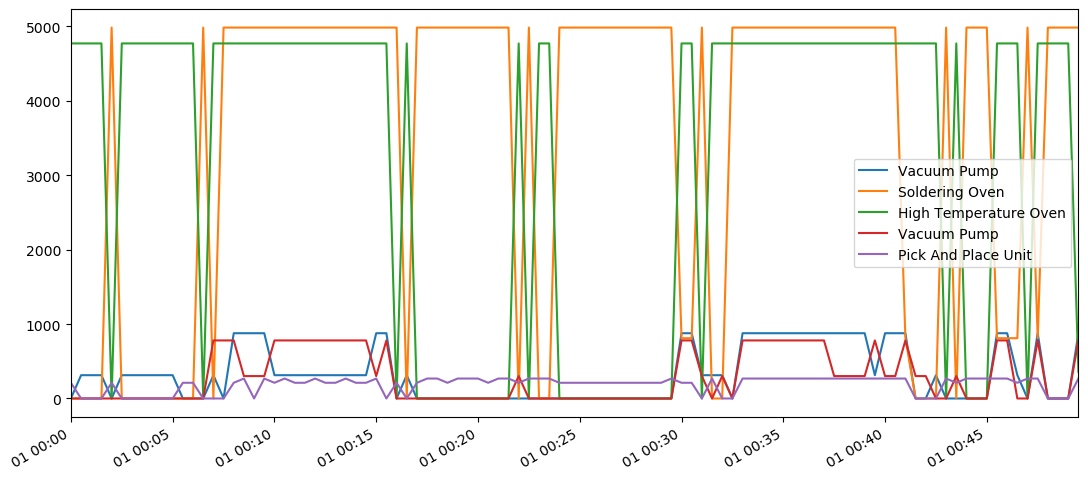

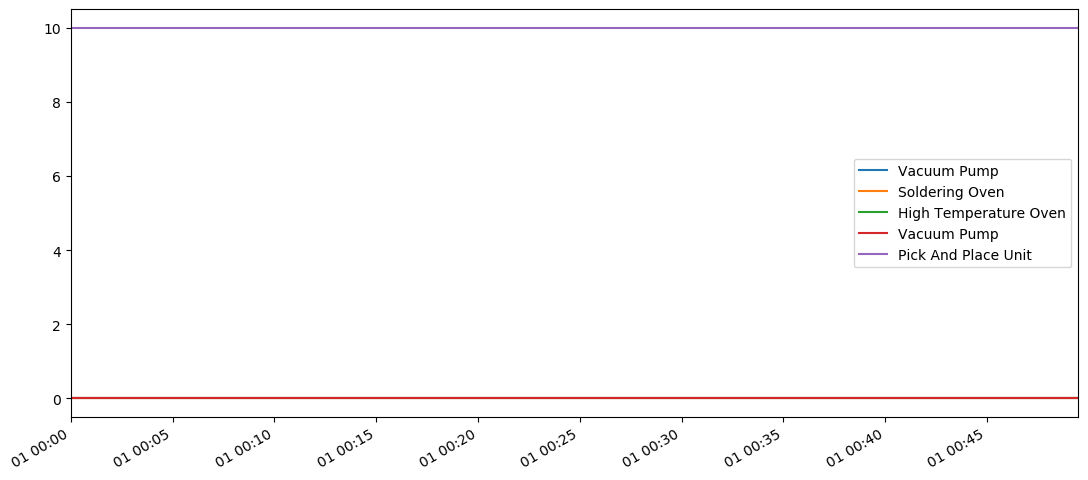

In [26]:
predictions['CO'].head(100).plot(label="Pred")
#predictions['CO'].plot(label="Pred")
gt.head(100).plot(label="GT")
plt.legend()

/home/lab-bonsai4/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


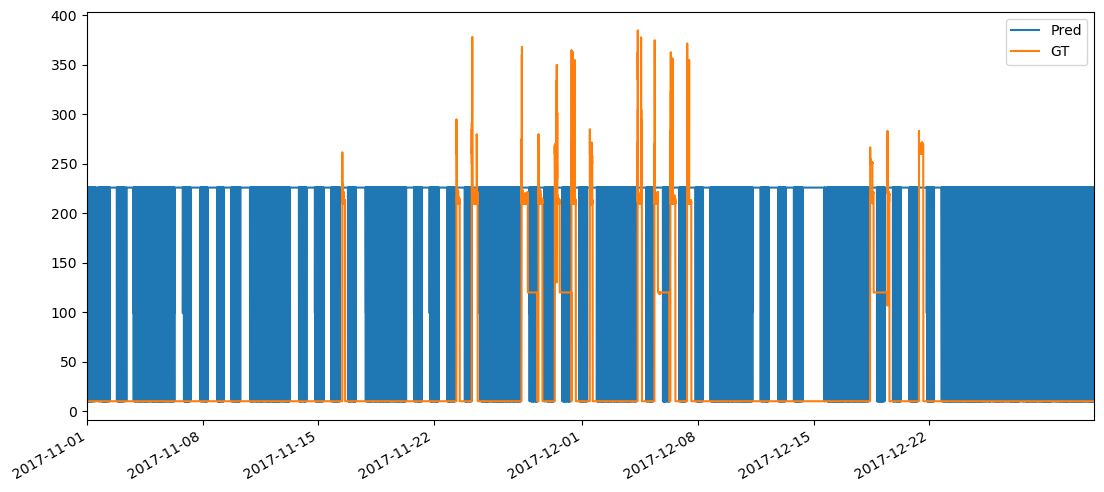

In [24]:
predictions['FHMM']['Pick And Place Unit'].plot(label="Pred")
gt['Pick And Place Unit'].plot(label="GT")
plt.legend()

### Comparing NILM algorithms (CO vs FHMM)

In [ ]:
? nilmtk.utils.compute_rmse

In [25]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse

,CO,FHMM
Vacuum Pump,637.974617,699.964946
Soldering Oven,4368.282397,6142.066869
High Temperature Oven,4260.123478,2961.978734
Pick And Place Unit,209.071014,168.465413
